In [1]:
!pip install datasets[audio]

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

import torchaudio
from torchaudio.transforms import Spectrogram

# Sample rate of 16,000 Hz
sample_rate = 16000

# Create a function to preprocess audio and convert it to a spectrogram
def preprocess_audio(audio, sample_rate):
    # Convert the audio to mono (if it's not already)
    audio = audio.mean(dim=0)

    # Resample audio to the desired sample rate (16,000 Hz)
    audio = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sample_rate)(audio)

    # Apply a Short-Time Fourier Transform (STFT) to create a spectrogram
    spectrogram = Spectrogram()(audio)

    return spectrogram

In [3]:
example = minds[14]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_38.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_38.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00024414,
         -0.00244141, -0.00317383]),
  'sampling_rate': 8000},
 'transcription': 'I need to pay a bill',
 'english_transcription': 'I need to pay a bill',
 'intent_class': 13,
 'lang_id': 2}

In [4]:
example = minds[0]  # Assuming you have an example from the dataset
audio_array = example['audio']['array']
array_size = audio_array.shape[0]

print(f"Array size: {array_size}")

Array size: 62415


In [5]:
example = minds[14]  # Assuming you have an example from the dataset
audio_array = example['audio']['array']
array_size = audio_array.shape[0]

print(f"Array size: {array_size}")

Array size: 27307


In [6]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [7]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

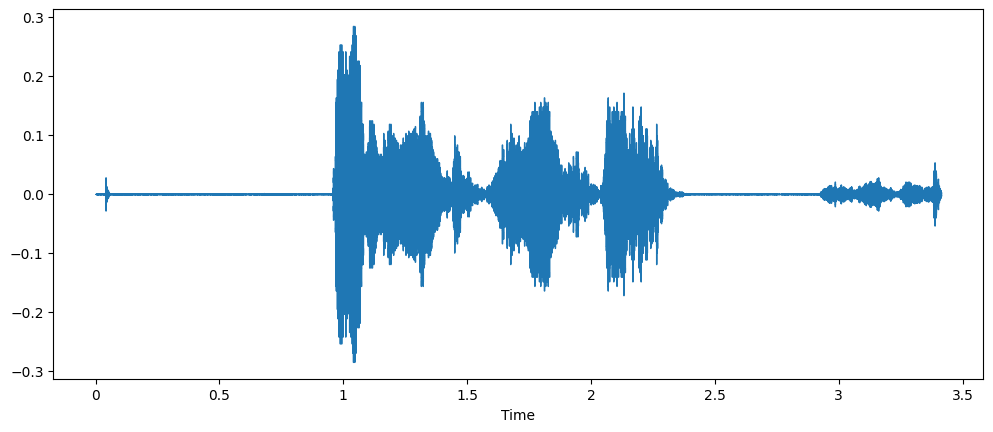

In [8]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [9]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [10]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [11]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [12]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [13]:
!pip install transformers

In [14]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [15]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=16000, padding=True
    )
    return features

In [16]:
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

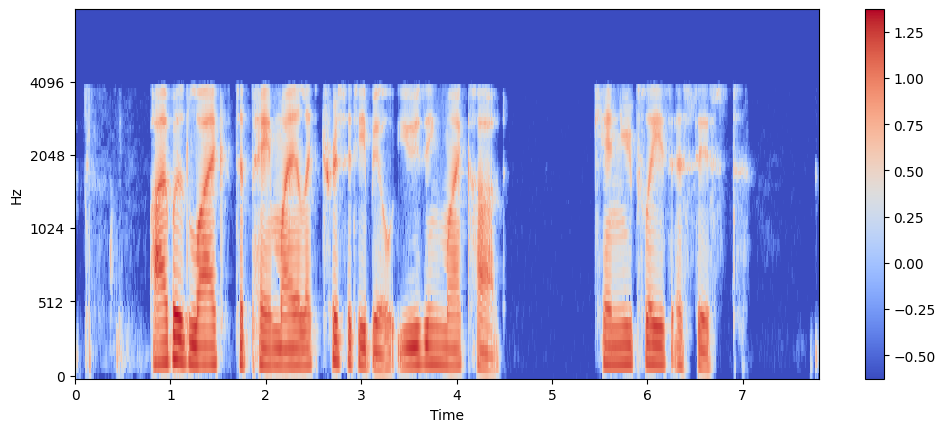

In [17]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [18]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [19]:
!pip install SentencePiece

In [20]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-2vj0qj_5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-2vj0qj_5
  Resolved https://github.com/huggingface/transformers.git to commit cc3e4781854a52cf090ffde28d884a527dab6708
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
!pip install sentencepiece

In [22]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [23]:
inputs = processor(text="Hey pawlay dev majha malhari", return_tensors="pt")

In [24]:
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

import torch

speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Generating validation split: 0 examples [00:00, ? examples/s]

In [25]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [26]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [27]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [28]:
from IPython.display import Audio

Audio(speech, rate=16000)

In [29]:
import torch
import torch.nn as nn

# Define your GAN generator on top of the Tacotron 2 model
class GANGenerator(nn.Module):
    def __init__(self, model, seq_len=150, latent_dim=100, embed_dim=10, channels=3):
        super(GANGenerator, self).__init__()

        self.tacotron2 = model
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Linear layer to map latent space to sequence
        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)

        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))

        # Deconvolutional layers to generate audio
        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, input_text, mel_specs):
        mel_output, _ = self.tacotron2(input_ids=input_text, mel_len=mel_specs.shape[1])

        latent = self.l1(mel_output)
        latent += self.pos_embed  # Add positional embeddings
        generated_audio = self.deconv(latent)

        return generated_audio  # Your final generated audio

# Create an instance of the GANGenerator
generator = GANGenerator(model)

# print(generator)

In [30]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [31]:
from torch import Tensor
import math
import numpy as np
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [41]:
class RealismDiscriminator(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super(RealismDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(hidden_dim*2*16000, 1)  # Adjust 'audio_length' to match your input shape

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class AlignmentDiscriminator(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super(AlignmentDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(hidden_dim*2*16000, 1)  # Adjust 'audio_length' to match your input shape

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=3,
                 patch_size=15,
                 emb_size=50,
                 seq_length = 150,
                 depth=3,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            RealismDiscriminator(in_channels = 2, hidden_dim=1),
            AlignmentDiscriminator(in_channels = 2, hidden_dim=1)
        )


discriminator = Discriminator()

In [33]:
from datasets import load_dataset

mind = load_dataset("PolyAI/minds14", name="en-AU", split="train")

from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
mind

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [34]:
import torch
import torchaudio
import numpy as np
from datasets import Dataset, load_dataset
import pandas as pd

# Load the original "PolyAI/minds14" dataset
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

# Define the desired size for audio arrays (e.g., 16000 samples)
desired_array_size = 16000

# Define a function to preprocess and pad the audio arrays
def preprocess_audio(example):
    audio = example['audio']['array']

    # Convert the NumPy array to a PyTorch tensor
    audio = torch.tensor(audio)

    if len(audio) < desired_array_size:
        # Pad the audio array to the desired size
        pad_size = desired_array_size - len(audio)
        audio = torch.cat((audio, torch.zeros(pad_size, dtype=audio.dtype)))
    elif len(audio) > desired_array_size:
        # Truncate the audio array to the desired size
        audio = audio[:desired_array_size]
    audio = torch.tensor(audio, dtype=torch.float32)
    return {'audio': audio, 'transcription': example['transcription']}

# Apply the preprocessing function to each example
preprocessed_examples = [preprocess_audio(example) for example in minds]

# Convert the PyTorch tensors to NumPy arrays
preprocessed_examples = [
    {
        'audio': example['audio'].numpy(),  # Convert to NumPy array
        'transcription': example['transcription']
    }
    for example in preprocessed_examples
]

# Create a DataFrame from the preprocessed examples
preprocessed_df = pd.DataFrame(preprocessed_examples)

# Create a dataset from the DataFrame
preprocessed_minds = Dataset.from_pandas(preprocessed_df)

# Save the preprocessed dataset to a JSON file, including transcriptions
preprocessed_minds.save_to_disk('preprocessed_minds_dataset')


<ipython-input-34-7d9857a9a64b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio, dtype=torch.float32)


Saving the dataset (0/1 shards):   0%|          | 0/654 [00:00<?, ? examples/s]

In [35]:
loaded_dataset = Dataset.load_from_disk('preprocessed_minds_dataset')

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

# Define a custom dataset
class CustomMindsDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        # You can preprocess the audio array or perform other tasks here
        audio_array = example['audio']['array']
        english_transcription = example['english_transcription']
        return english_transcription, audio_array

# Load the "PolyAI/minds14" dataset
minds_dataset = load_dataset("PolyAI/minds14", name="en-AU", split="train")

# Create a custom dataset instance
custom_dataset = CustomMindsDataset(minds_dataset)



    # Process the batch as needed
    # 'english_transcription' is a list of English transcriptions
    # 'audio' is a list of audio arrays


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# Initialize the dataset and data loader
# Define a DataLoader for batching
batch_size = 16  # You can adjust the batch size
data_loader = DataLoader(loaded_dataset, batch_size=4, shuffle=True, num_workers=6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define your loss functions and optimizers
criterion_generator = nn.MSELoss()
criterion_discriminator = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch in data_loader:
        # Move data to the device
        transcription, audio = batch['transcription'], batch['audio']

        # Discriminator update
        optimizer_discriminator.zero_grad()
        real_outputs = discriminator(audio)
        real_labels = torch.ones(real_outputs.size(0), 1)
        loss_real = criterion_discriminator(real_outputs, real_labels)

        fake_audio = generator(transcription)
        fake_outputs = discriminator(fake_audio.detach())  # Detach the generator's output
        fake_labels = torch.zeros(fake_outputs.size(0), 1)
        loss_fake = criterion_discriminator(fake_outputs, fake_labels)

        discriminator_loss = loss_real + loss_fake
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # Generator update
        optimizer_generator.zero_grad()
        generator_outputs = generator(transcription)
        discriminator_outputs = discriminator(generator_outputs)
        generator_loss = criterion_discriminator(discriminator_outputs, real_labels)
        generator_loss.backward()
        optimizer_generator.step()


        # Monitor and log losses, and save checkpoints if needed
        # def save_checkpoint(args, generator, discriminator,
        #                     g_optimizer, d_optimizer, step, ema=None):
        #     checkpoint_path = os.path.join(args.checkpoint_dir, "model.ckpt-{}.pt".format(step))

        #     torch.save({"generator": generator.state_dict(),
        #                 "discriminator": discriminator.state_dict(),
        #                 "g_optimizer": g_optimizer.state_dict(),
        #                 "d_optimizer": d_optimizer.state_dict(),
        #                 "global_step": step
        #                 }, checkpoint_path)

        #     print("Saved checkpoint: {}".format(checkpoint_path))

        #     with open(os.path.join(args.checkpoint_dir, 'checkpoint'), 'w') as f:
        #         f.write("model.ckpt-{}.pt".format(step))

        #   print(save_checkpoint)

# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.10/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 428, in reduce_storage
    fd, size = storage._share_fd_cpu_()
  File "/usr/local/lib/python3.10/dist-packages/torch/storage.py", line 297, in wrapper
    return fn(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/storage.py", line 330, in _share_fd_cpu_
    return super()._share_fd_cpu_(*args, **kwargs)
RuntimeError: unable to mmap 32 bytes from file </torch_7059_3350066596_13774>: Cannot allocate memory (12)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.10/multiprocessing/reduction.py", line